In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from IPython.display import clear_output

try:
    import transformers
except ModuleNotFoundError:
    !pip install sentencepiece
    !pip install transformers
    clear_output()
    import transformers

In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/future_dataset/labels.csv', index_col=0)
type(df['решение'][0])

numpy.bool_

In [4]:
def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^а-яА-Я?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    # URLs
    text = re.sub(r"http\S+", "",text) #Removing URLs
    #text = re.sub(r"http", "",text)

    # html tags
    html=re.compile(r'<.*?>')
    text = html.sub(r'',text) #Removing html tags

    # punctuations
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p, '') #Removing punctuations

    return text

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [6]:
import torch
from torch.utils.data import Dataset
class CasesDataset(Dataset):
    def __init__(self, df_data, datapath, transform, tokenizer):
        self.datapath = datapath
        self.df_data = df_data
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):

        with open(self.datapath+self.df_data['название'][idx]) as f:
            tax_case = f.read()
        label = int(self.df_data['решение'][idx])
        tax_case = self.transform(tax_case)

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = self.tokenizer.encode_plus(
            tax_case,                      # Sentence to encode.
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = 2048,           # Pad & truncate all sentences.
            pad_to_max_length = True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',     # Return pytorch tensors.
        )
        return encoded_dict['input_ids'][0], encoded_dict['attention_mask'][0],  label

In [7]:
df['название'] = df['название'].apply(lambda x: x[:-4]+'_motiv.txt')
df

,название,решение
0,тДЦ ╨Р01-4372_2021_motiv.txt,True
1,тДЦ ╨Р36-7619_2020_motiv.txt,True
2,тДЦ ╨Р33-4569_2022_motiv.txt,True
3,тДЦ ╨Р81-2524_2022_motiv.txt,True
4,тДЦ ╨Р03-1138_2022_motiv.txt,False
...,...,...
1142,тДЦ ╨Р73-163_2022_motiv.txt,False
1143,тДЦ ╨Р73-16731_2021_motiv.txt,False
1144,тДЦ ╨Р51-3250_2021_motiv.txt,False
1145,тДЦ ╨Р40-73113_2022_motiv.txt,True


In [8]:
data = CasesDataset(df, '/content/drive/MyDrive/future_dataset/motiv/', clean_text, tokenizer)

In [9]:
drop_list = []
for ind, row in df.iterrows():
    try:
        with open('/content/drive/MyDrive/future_dataset/motiv/'+row['название']) as f:
            tax_case = f.read()
    except:
        drop_list.append(ind)
drop_list

[9,
 117,
 199,
 206,
 217,
 227,
 289,
 304,
 310,
 342,
 416,
 431,
 446,
 465,
 474,
 542,
 546,
 624,
 694,
 772,
 824,
 857,
 874,
 883,
 896,
 912,
 913,
 921,
 1097,
 1118,
 1121]

In [10]:
df = df.drop(drop_list).reset_index(drop=True)
df

,название,решение
0,тДЦ ╨Р01-4372_2021_motiv.txt,True
1,тДЦ ╨Р36-7619_2020_motiv.txt,True
2,тДЦ ╨Р33-4569_2022_motiv.txt,True
3,тДЦ ╨Р81-2524_2022_motiv.txt,True
4,тДЦ ╨Р03-1138_2022_motiv.txt,False
...,...,...
1111,тДЦ ╨Р73-163_2022_motiv.txt,False
1112,тДЦ ╨Р73-16731_2021_motiv.txt,False
1113,тДЦ ╨Р51-3250_2021_motiv.txt,False
1114,тДЦ ╨Р40-73113_2022_motiv.txt,True


In [11]:
drop_list = []
for ind, row in df.iterrows():
    with open('/content/drive/MyDrive/future_dataset/motiv/'+row['название']) as f:
        tax_case = f.read()
    if len(tax_case)<5_000:
        drop_list.append(ind)

In [12]:
df = df.drop(drop_list).reset_index(drop=True)
df

,название,решение
0,тДЦ ╨Р01-4372_2021_motiv.txt,True
1,тДЦ ╨Р36-7619_2020_motiv.txt,True
2,тДЦ ╨Р33-4569_2022_motiv.txt,True
3,тДЦ ╨Р81-2524_2022_motiv.txt,True
4,тДЦ ╨Р03-1138_2022_motiv.txt,False
...,...,...
1104,тДЦ ╨Р73-163_2022_motiv.txt,False
1105,тДЦ ╨Р73-16731_2021_motiv.txt,False
1106,тДЦ ╨Р51-3250_2021_motiv.txt,False
1107,тДЦ ╨Р40-73113_2022_motiv.txt,True


In [13]:
df['решение'].sum()/len(df)

0.5347159603246168

In [14]:
df['решение'].sum()

593

In [15]:
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer, get_linear_schedule_with_warmup

Проверяем девайс

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Проверка на максимальное количество токенов

In [17]:
data = CasesDataset(df, '/content/drive/MyDrive/future_dataset/motiv/', clean_text, tokenizer)

In [18]:
from tqdm.notebook import tqdm
max_len = 0
tocken_len = []
# For every sentence...
for ind, row in df.iterrows():
    with open('/content/drive/MyDrive/future_dataset/motiv/'+row['название']) as f:
        tax_case = clean_text(f.read())

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tax_case, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    tocken_len.append(len(input_ids))
print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (2691 > 2048). Running this sequence through the model will result in indexing errors


Max sentence length:  80543


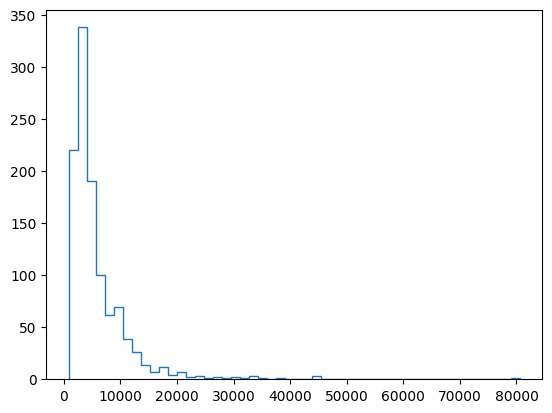

In [19]:
import matplotlib.pyplot as plt
import numpy as np

counts, bins = np.histogram(tocken_len, 50)
plt.stairs(counts, bins)

Не Помещаемся!!!

In [20]:
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

mask = np.random.rand(len(df))
train_df = df[mask<=0.8].reset_index(drop=True)
val_df = df[np.logical_and(0.8<mask, mask<=0.9)].reset_index(drop=True)
test_df = df[mask>0.9].reset_index(drop=True)

In [21]:
type(test_df)

pandas.core.frame.DataFrame

Тут нужно поправить, надо три разбиения

In [22]:
datapath = '/content/drive/MyDrive/future_dataset/motiv/'

train_dataset = CasesDataset(train_df, datapath, clean_text, tokenizer)
val_dataset = CasesDataset(val_df, datapath, clean_text, tokenizer)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

  880 training samples
  111 validation samples


In [23]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2

In [25]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [26]:
optimizer = AdamW(model.classifier.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [28]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



  Average training loss: 0.69
  Training epcoh took: 0:01:51

Running Validation...
  Accuracy: 0.55

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:01:41

Running Validation...
  Accuracy: 0.55

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.56

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.69
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.57

Training complete!
Total training took 0:07:18 (h:mm:ss)


In [31]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                 )

In [32]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.62
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.72

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.51
  Training epcoh took: 0:01:40

Running Validation...
  Accuracy: 0.75

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.47
  Training epcoh took: 0:01:41

Running Validation...
  Accuracy: 0.78

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.43
  Training epcoh took: 0:01:41

Running Validation...
  Accuracy: 0.79

Training complete!
Total training took 0:07:09 (h:mm:ss)


In [33]:
"""PATH = "/content/drive/MyDrive/model_1.pt"

torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_val_loss,
}, PATH)
"""

'PATH = "/content/drive/MyDrive/model_1.pt"\n\ntorch.save({\n    \'epoch\': epochs,\n    \'model_state_dict\': model.state_dict(),\n    \'optimizer_state_dict\': optimizer.state_dict(),\n    \'loss\': avg_val_loss,\n}, PATH)\n'

In [34]:
test_dataset = CasesDataset(test_df, datapath, clean_text, tokenizer)

In [35]:
# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
    test_dataset, # The validation samples.
    sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

In [36]:
# ========================================
#               TEST
# ========================================
# After the completion of each training epoch, measure our performance on
# our validation set.
print("")
print("Running Test...")
t0 = time.time()
# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()
# Tracking variables
total_eval_accuracy = 0
best_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0
# Evaluate data for one epoch
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        output= model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
# Calculate the average loss over all of the batches.
vg_val_loss = total_eval_loss / len(test_dataloader)
# Measure how long the validation run took.
validation_time = format_time(time.time() - t0)
if avg_val_accuracy > best_eval_accuracy:
    torch.save(model, 'bert_model')
    best_eval_accuracy = avg_val_accuracy
#print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#print("  Validation took: {:}".format(validation_time))
# Record all statistics from this epoch.
training_stats.append(
    {
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Valid. Accur.': avg_val_accuracy,
        'Training Time': training_time,
        'Validation Time': validation_time
    }
)


Running Test...
  Accuracy: 0.76


загрузка модели

In [37]:
"""def load_my_model(model):
    PATH = "/content/drive/MyDrive/model_1.pt"
    model.load_state_dict(torch.load(PATH)['model_state_dict'])
    model.eval()
    return model
"""

'def load_my_model(model):\n    PATH = "/content/drive/MyDrive/model_1.pt"\n    model.load_state_dict(torch.load(PATH)[\'model_state_dict\'])\n    model.eval()\n    return model\n'

In [38]:
"""model_saved = BertForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model_saved = load_my_model(model_saved)
model_saved.to(device)
"""

'model_saved = BertForSequenceClassification.from_pretrained(\n    "cointegrated/rubert-tiny2",\n    num_labels = 2,\n    output_attentions = False,\n    output_hidden_states = False,\n)\nmodel_saved = load_my_model(model_saved)\nmodel_saved.to(device)\n'

In [39]:
# roc curve for logistic regression model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

0.8538812785388127


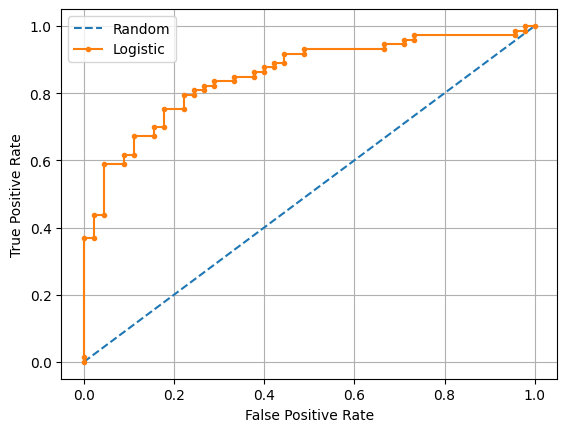

In [40]:
probs_list = []
true_labels = []

test_dataloader_2 = DataLoader(
    test_dataset, # The validation samples.
    sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
    batch_size = 4 # Evaluate with this batch size.
)
sf = nn.Softmax(dim=1)
for batch in test_dataloader_2:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    output = model(b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels)
    # Move logits and labels to CPU if we are using GPU
    logits = output.logits
    logits = logits.detach()
    label_ids = b_labels.to('cpu').numpy()
    probs = sf(logits).to('cpu').numpy()
    true_labels.extend(label_ids)
    probs_list.extend(probs[:,1])

probs_list = np.array(probs_list)
true_labels = np.array(true_labels)

fpr, tpr, thresholds = roc_curve(true_labels, probs_list)
roc_auc = roc_auc_score(true_labels, probs_list)

print(roc_auc)

    # plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='Random')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    # axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
    # show the plot
pyplot.grid()
pyplot.show()